Using the algorithms from this paper: https://arxiv.org/pdf/2304.09224v2


In [1]:
# imports
import torch.nn as nn
import pennylane as qml
import torch
from pennylane import numpy as np
import sys
import os
from PIL import Image

## Overall structure

```
ALGORITHM: HQNN-Parallel
INPUT: Image x of size 28×28 (for MNIST)
OUTPUT: Class probability distribution over 10 classes

FUNCTION HQNN_Parallel(x):
    // Classical Convolutional Feature Extraction
    features = ClassicalConvolutionalBlock(x)

    // Hybrid Dense Processing
    quantum_output = ParallelQuantumLayers(features)

    // Final Classification
    output = ClassicalDenseLayer(quantum_output)

    RETURN output
```

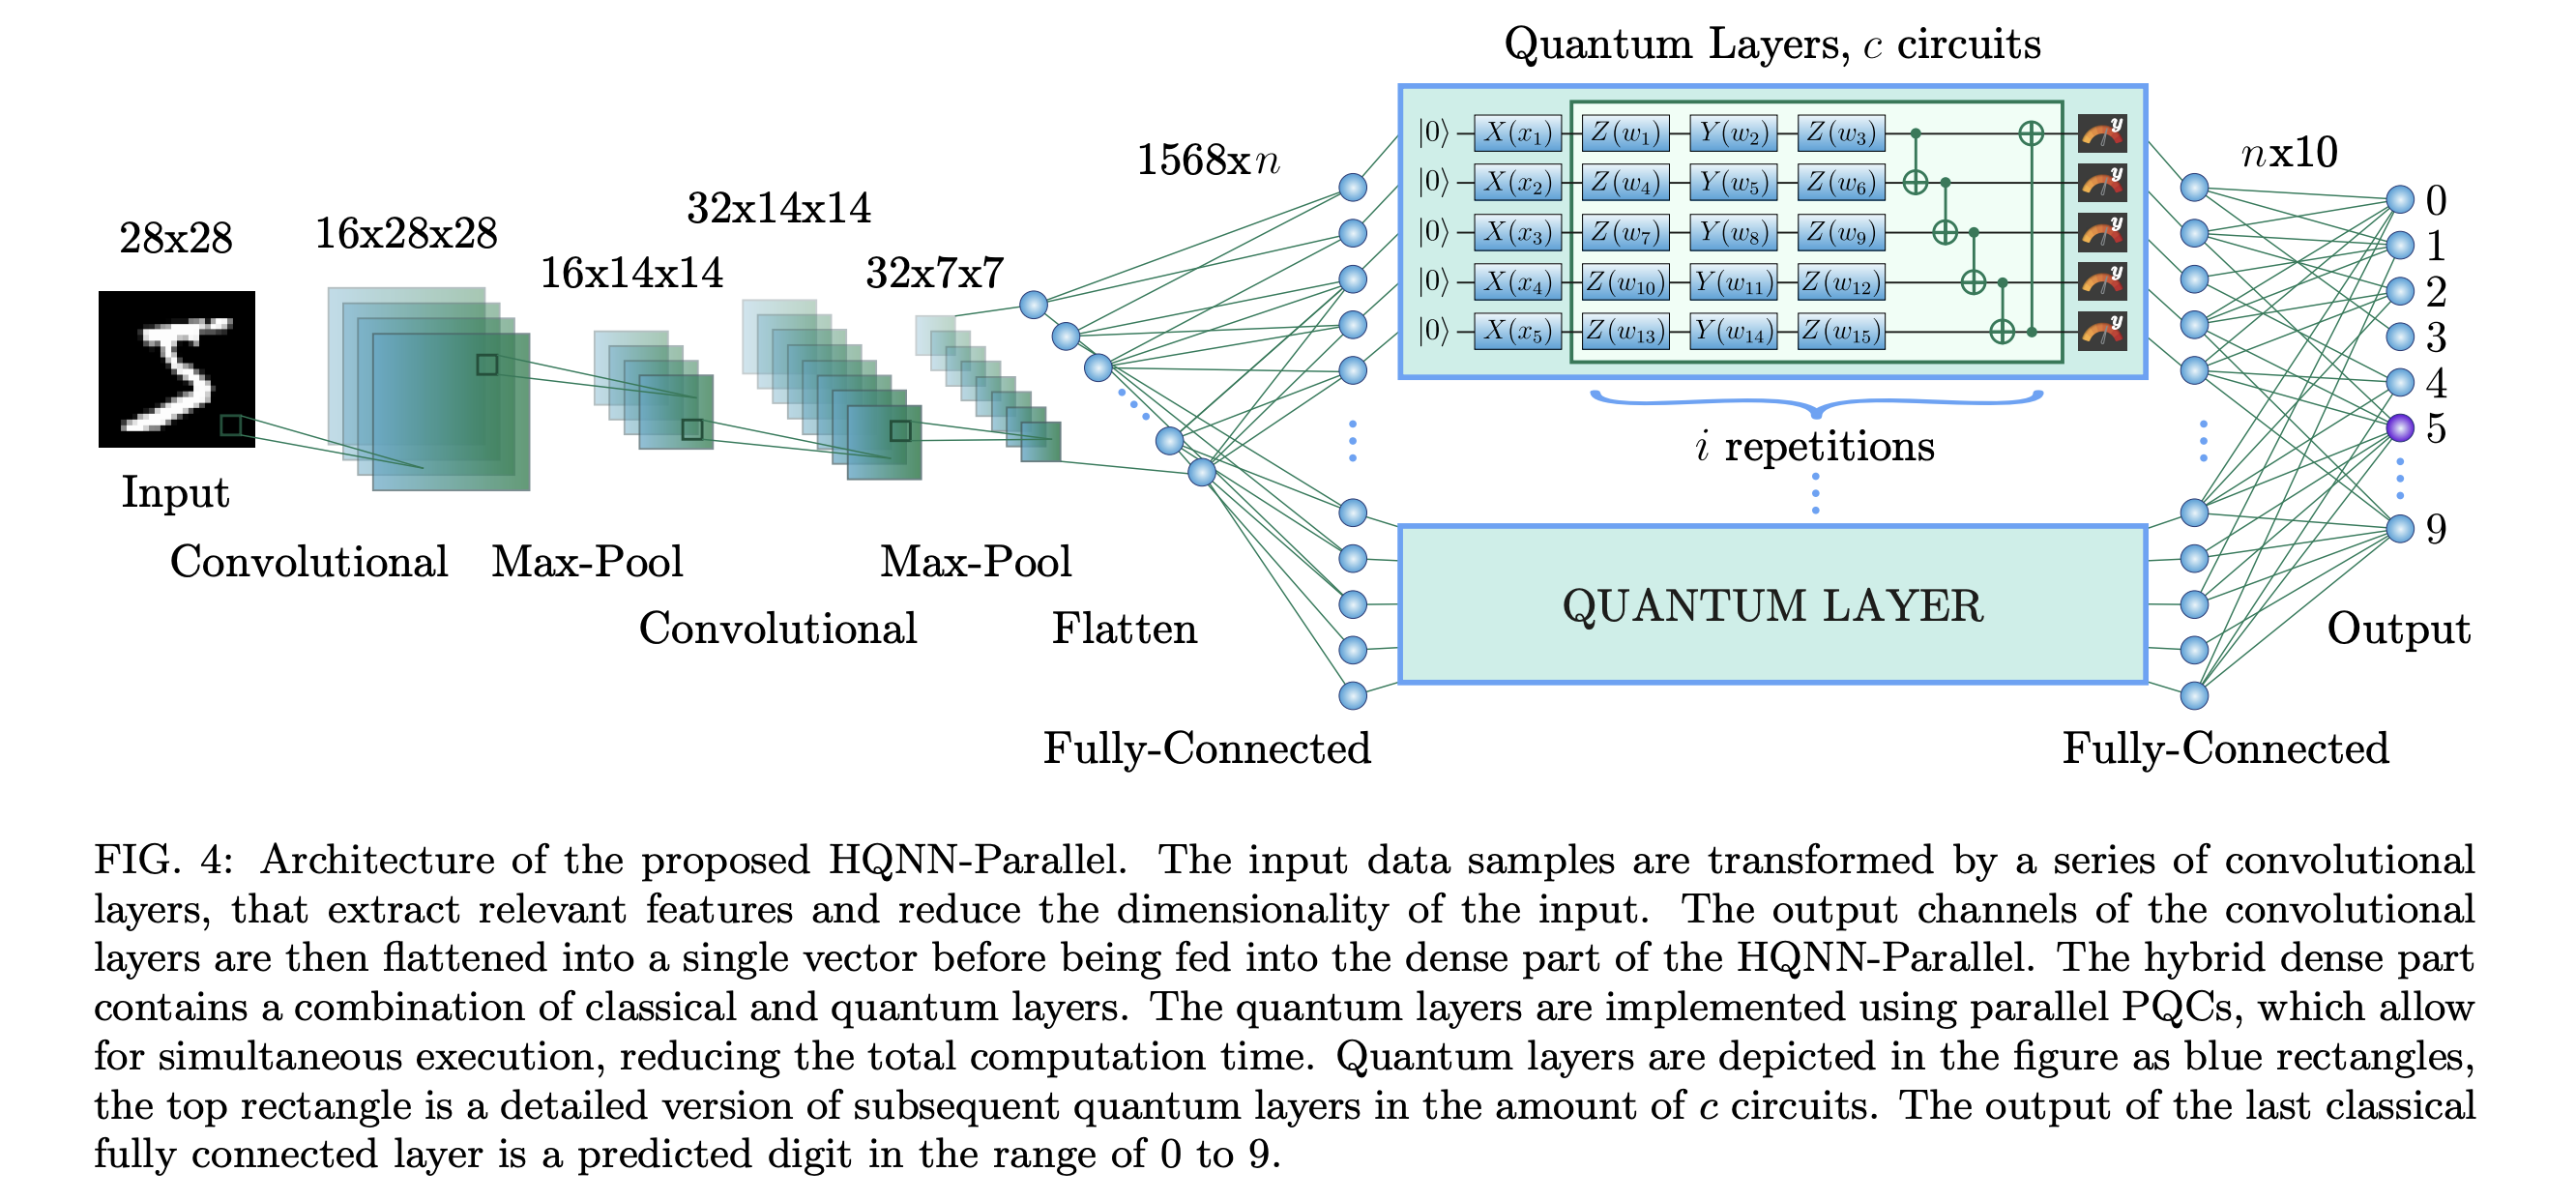


## Classical Convolutional Feature Extraction

```
FUNCTION ClassicalConvolutionalBlock(input_image):
    // First Convolutional Block
    conv1 = Conv2D(input_channels=1, output_channels=16, kernel_size=5×5,
                   stride=1, padding=2)(input_image)
    norm1 = BatchNormalization(conv1)
    relu1 = ReLU(norm1)
    pool1 = MaxPool2D(kernel_size=2×2)(relu1)  // Output: 16×14×14

    // Second Convolutional Block
    conv2 = Conv2D(input_channels=16, output_channels=32, kernel_size=5×5,
                   stride=1, padding=2)(pool1)
    norm2 = BatchNormalization(conv2)
    relu2 = ReLU(norm2)
    pool2 = MaxPool2D(kernel_size=2×2)(relu2)  // Output: 32×7×7

    // Flatten for dense layers
    flattened = Flatten(pool2)  // Output: 1568 features

    RETURN flattened
```


In [2]:
ClassicalConvBlock = nn.Sequential(
    # First Convolutional Block
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # Output: (batch, 16, 14, 14)

    # Second Convolutional Block
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), # Output: (batch, 32, 7, 7)

    # Flatten for dense layers
    nn.Flatten() # Output: (batch, 1568)
)

### Testing the ClassicalConvBlock


Image tensor shape: torch.Size([1, 28, 28])
Label: 7
Min value: 0.0, Max value: 1.0
PyTorch tensor shape for model: torch.Size([1, 1, 28, 28])


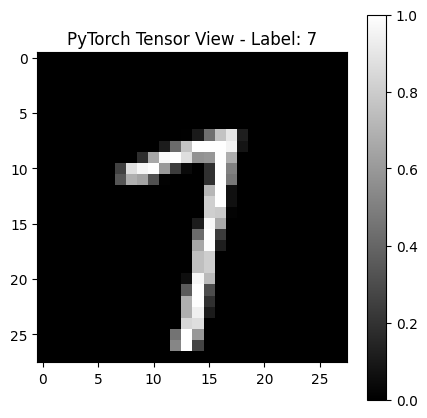

Output shape of ClassicalConvBlock: torch.Size([1, 1568])


In [3]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch

# Define a transform to convert images to PyTorch tensors and normalize to [0, 1]
transform = transforms.ToTensor()

# Load MNIST dataset using torchvision
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Select a single image
img_idx = 42  # Choose an arbitrary index
img_tensor, label = train_dataset[img_idx]  # The transform is applied automatically

# Print information about the image
# The tensor is already in [channels, height, width] format
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Label: {label}")
print(f"Min value: {img_tensor.min()}, Max value: {img_tensor.max()}")

# Add a batch dimension for processing with the model
# PyTorch expects format: [batch_size, channels, height, width]
img_tensor = img_tensor.unsqueeze(0)
print(f"PyTorch tensor shape for model: {img_tensor.shape}")  # Should be [1, 1, 28, 28]

# For visualization of tensor format
plt.figure(figsize=(5, 5))
# We use .squeeze() to remove the batch and channel dimensions for plotting
plt.imshow(img_tensor.squeeze().numpy(), cmap='gray')
plt.title(f"PyTorch Tensor View - Label: {label}")
plt.colorbar()
plt.grid(False)
plt.show()

# Test the convolutionalblock
features = ClassicalConvBlock(img_tensor)
print(f"Output shape of ClassicalConvBlock: {features.shape}")

## Parallel Quantum Layers

```
FUNCTION ParallelQuantumLayers(features):
    // First classical dense layer to prepare quantum input
    dense_features = DenseLayer(input_size=1568, output_size=n)(features)
    dense_features = BatchNormalization(dense_features)
    dense_features = ReLU(dense_features)

    // Divide features into c parallel quantum circuits
    // where n = c × q (c circuits, q qubits each)
    quantum_inputs = Split(dense_features, num_parts=c)

    // Process each part through parallel quantum circuits
    quantum_outputs = []
    FOR i = 1 TO c:
        qc_output = QuantumCircuit(quantum_inputs[i], qubits=q, depth=d)
        quantum_outputs.append(qc_output)

    // Concatenate all quantum outputs
    concatenated_output = Concatenate(quantum_outputs)

    RETURN concatenated_output
```

### Individual Quantum Circuit within each layer:

```
FUNCTION ParallelCircuit(input_vector, qubits, depth):
    // Initialize quantum state
    state = |0⟩^⊗qubits

    // Angle embedding: encode classical data into quantum state
    FOR j = 1 TO qubits:
        state = RX(input_vector[j]) × state  // Rotate around Y-axis

    // Variational quantum circuit with depth repetitions
    FOR layer = 1 TO depth:
        // Trainable rotation gates
        FOR j = 1 TO qubits:
            state = RX(θ_x[layer][j]) × state
            state = RY(θ_y[layer][j]) × state
            state = RZ(θ_z[layer][j]) × state

        // Entangling gates (CNOT operations)
        FOR j = 1 TO qubits-1:
            state = CNOT(j, j+1) × state

    // Measurement: compute expectation values
    measurements = []
    FOR j = 1 TO qubits:
        expectation = ⟨state| Pauli_Y[j] |state⟩
        measurements.append(expectation)

    RETURN measurements
```


In [18]:
from tqdm import tqdm

class ParallelQuantumLayer(nn.Module):
    """
    A PyTorch module for the parallel quantum layers.
    
    This module includes a classical preprocessing layer and a set of parallel
    quantum circuits implemented with PennyLane. It's designed to be a drop-in
    replacement in a PyTorch model.
    """
    def __init__(self, n_qubits, n_circuits, depth, device='local', shots=None):
        """
        Args:
            n (int): The number of features coming from the CNN (e.g., 1568).
            n_qubits (int): The number of qubits in each quantum circuit.
            depth (int): The depth of the variational part of each quantum circuit.
            device (str): The PennyLane device to use.
            shots (int, optional): The number of shots for measurements. None for exact expectation.
        """
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_circuits = n_circuits
        self.depth = depth
        self.device = device
        self.shots = shots
        self.total_quantum_features = n_circuits * n_qubits

        # --- 1. Classical Preprocessing Layer ---
        # This layer maps the flattened CNN output to the total number of features
        # required by all parallel quantum circuits.
        self.classical_preprocessor = nn.Sequential(
            nn.LazyLinear(self.total_quantum_features),
            nn.BatchNorm1d(self.total_quantum_features),
            nn.ReLU()
        )

        # --- 2. Quantum Device and Circuit Definition ---
        # We define a single quantum device and a QNode template.
        dev = self._initialize_device()

        @qml.qnode(dev, interface='torch', diff_method='parameter-shift')
        def quantum_circuit(inputs, weights):
            """The quantum circuit template for a single parallel layer."""
            # Reshape weights for easier indexing
            weights = weights.reshape(depth, 3, n_qubits)
            
            # Encode classical data using Angle Embedding
            # Scale inputs to [-π, π] range for angle embedding
            # This ensures proper rotation angles for the quantum gates
            scaled_weights = inputs * torch.pi
            qml.AngleEmbedding(scaled_weights, wires=range(n_qubits), rotation='X')

            # Apply variational layers (trainable)
            for layer_id in range(depth):
                # Trainable rotation gates
                for i in range(n_qubits):
                    qml.RZ(weights[layer_id, 0, i], wires=i)
                    qml.RY(weights[layer_id, 1, i], wires=i)
                    qml.RZ(weights[layer_id, 2, i], wires=i)
                
                # Entangling gates
                for i in range(n_qubits):
                    qml.CNOT(wires=[i, (i + 1) % n_qubits])

                # Add a barrier to align the layers
                qml.Barrier(wires=range(n_qubits))

            # Return expectation values for each qubit
            return [qml.expval(qml.PauliY(i)) for i in range(n_qubits)]

        # --- 3. Create TorchLayers for Parallel Execution ---
        # We use qml.qnn.TorchLayer to wrap our QNode. This makes it a proper
        # PyTorch layer. We create a list of these layers, one for each parallel circuit.
        self.quantum_weights = nn.ParameterList([
            nn.Parameter(torch.randn(depth * 3 * n_qubits)) for _ in range(self.n_circuits)
        ])
        self.quantum_circuit = quantum_circuit  # Save the QNode for later use

        # Display one of the circuits for visualization
        print("--- Quantum Circuit Structure ---")
        # Create dummy inputs for drawing
        dummy_inputs = torch.zeros(self.n_qubits)
        dummy_weights = torch.zeros(self.depth * 3 * self.n_qubits)
        # Draw the circuit
        fig, ax = qml.draw_mpl(self.quantum_circuit)(dummy_inputs, dummy_weights)
        plt.show()
        print("-------------------------------")

    def forward(self, x):
        """
        The forward pass for the parallel quantum layer.
        
        Args:
            x (torch.Tensor): Input tensor from the CNN of shape (batch_size, cnn_output_size).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_circuits * n_qubits).
        """
        # 1. Pass input through the classical preprocessor
        processed_features = self.classical_preprocessor(x)
        
        # 2. Split the features for each parallel quantum circuit.
        # The tensor is split along the feature dimension (dim=1).
        split_features = torch.split(processed_features, self.n_qubits, dim=1)

        batch_size = x.shape[0]

        # loop over the batch for gradient computation
        quantum_outputs = []
        for i in range(self.n_circuits):
            outputs_for_circuit = []
            for j in tqdm(range(batch_size), desc=f"Circuit {i+1}/{self.n_circuits}..."):
                # Pass one sample at a time to the quantum layer
                single_input = split_features[i][j]
                out = self.quantum_circuit(single_input, self.quantum_weights[i])
                outputs_for_circuit.append(torch.tensor(out).unsqueeze(0))
            # Stack outputs for this circuit
            quantum_outputs.append(torch.cat(outputs_for_circuit, dim=0))

            print(f"  [QuantumLayer] Finished circuit {i+1}/{self.n_circuits} for batch of size {batch_size}")

        # Concatenate all circuits' outputs
        return torch.cat(quantum_outputs, dim=1).float()

    def _initialize_device(self):
        """
        Initialize the quantum device for the parallel circuits.

        Options:
            - 'local':                  Use local machine lightning.qubit simulator
            - 'simulator':              Use IonQ simulator (no noise model)
            - 'simulator.aria-1':       Use IonQ simulator with aria-1 noise model
            - 'simulator.forte-1':      Use IonQ simulator with forte-1 noise model
            - 'qpu.aria-1':             Use real IonQ Aria-1 quantum hardware
            - 'qpu.aria-2':             Use real IonQ Aria-2 quantum hardware
            - 'qpu.forte-1':            Use real IonQ Forte-1 quantum hardware
            - 'qpu.forte-enterprise-1': Use real IonQ Forte-Enterprise-1 quantum hardware


        Returns:
            - dev (qml.Device): The PennyLane device to use for quantum computations.
        """
        api_key = self._load_api_key()
        if api_key:
            if self.device == 'local':
                dev = qml.device('lightning.qubit', wires=self.n_qubits, shots=self.shots)
            elif self.device == 'simulator':
                dev = qml.device('ionq.simulator', wires=self.n_qubits, api_key=api_key, shots=self.shots)
            elif self.device.startswith('simulator.'):
                dev = qml.device('ionq.simulator', target=self.device, wires=self.n_qubits, api_key=api_key, shots=self.shots)
            elif self.device.startswith('qpu.'):
                dev = qml.device('ionq.qpu', target=self.device, wires=self.n_qubits, api_key=api_key, error_mitigation={"debias": False}, shots=self.shots)
            else:
                raise ValueError('Invalid device name given.')
        else:
            print("No API key found. Using local device instead.")
            dev = qml.device('lightning.qubit', wires=self.n_qubits, shots=self.shots)

        return dev
    
    # Load API key
    def _load_api_key(self):
        try:
            with open('api-key.txt', 'r') as f:
                return f.read().strip()
        except FileNotFoundError:
            print("API key file not found. Please create api-key.txt with your IonQ API key.")
            return None

--- Quantum Circuit Structure ---


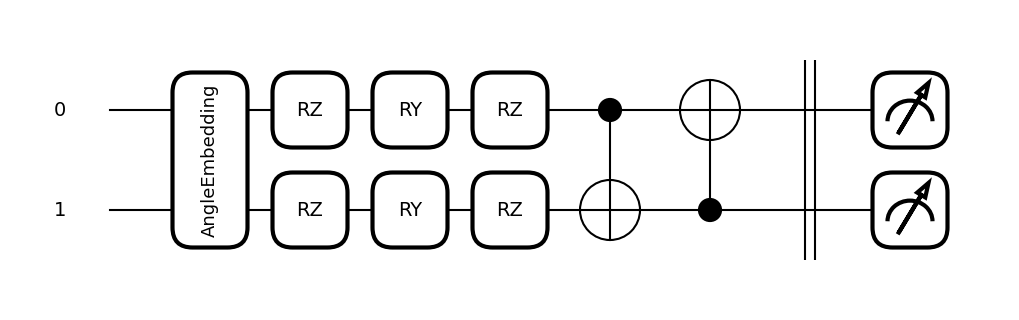

-------------------------------


Circuit 1/1...: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]

  [QuantumLayer] Finished circuit 1/1 for batch of size 3
Input shape to ParallelQuantumLayer: torch.Size([3, 1568])
Output shape from ParallelQuantumLayer: torch.Size([3, 2])
Expected output shape: (3, 2)


In [12]:
# --- Example of how to test this layer ---
# Hyperparameters
q = 2      # Number of qubits per circuit
c = 1      # Number of parallel circuits
depth = 1  # Depth of each circuit
shots = 100

# Create an instance of the layer
parallel_q_layer = ParallelQuantumLayer(
    n_qubits=q,
    n_circuits=c,
    depth=depth,
    device='simulator',
    shots=shots
)

# Create a dummy input tensor (simulating output from the CNN block)
batch_size = 3
dummy_cnn_features = torch.randn(batch_size, 1568)

# Pass the dummy data through the layer
output_features = parallel_q_layer(dummy_cnn_features)

print(f"Input shape to ParallelQuantumLayer: {dummy_cnn_features.shape}")
print(f"Output shape from ParallelQuantumLayer: {output_features.shape}")
print(f"Expected output shape: ({batch_size}, {c * q})")

## Final Classification Layer

```
FUNCTION ClassicalDenseLayer(quantum_features):
    // Final dense layer for classification
    logits = DenseLayer(input_size=n, output_size=10)(quantum_features)
    logits = BatchNormalization(logits)
    logits = ReLU(logits)

    // Convert to probabilities
    probabilities = Softmax(logits)

    RETURN probabilities
```


In [6]:
def ClassicalDenseLayer(quantum_output_size, n_classes):
    return nn.Sequential(
        nn.Linear(quantum_output_size, n_classes),
        nn.BatchNorm1d(n_classes),
    )

In [13]:
# --- Example of how to test this layer ---
# Dummy Hyperparameters
# using same q, c as in the previous test
n_classes = 10

# Use the output from the previous quantum layer test as input here
dummy_quantum_features = output_features

# Pass the dummy data through the layer
quantum_output_size = c * q
layer = ClassicalDenseLayer(quantum_output_size, n_classes)
final_probabilities = layer(dummy_quantum_features)

print(f"Input shape to ClassicalDenseLayer: {dummy_quantum_features.shape}")
print(f"Output shape from ClassicalDenseLayer: {final_probabilities.shape}")
print(f"Expected output shape: ({batch_size}, {n_classes})")

# Check if the output is a valid probability distribution
# The sum of probabilities for each sample in the batch should be 1.0
print(f"\nSum of probabilities for the first sample: {torch.sum(final_probabilities[0])}")
print(f"Output for the first sample: \n{final_probabilities[0].detach().numpy()}")

Input shape to ClassicalDenseLayer: torch.Size([3, 2])
Output shape from ClassicalDenseLayer: torch.Size([3, 10])
Expected output shape: (3, 10)

Sum of probabilities for the first sample: 5.965958595275879
Output for the first sample: 
[ 0.94872904  1.0204188   1.0499578   1.0231357   0.98125863 -0.94017917
  0.8572445   1.0837042  -0.9093952   0.8510844 ]


## Training Loop

```
ALGORITHM: Train_HQNN_Parallel
INPUT: Training dataset D, learning parameters
OUTPUT: Trained model parameters

FUNCTION TrainModel(dataset, epochs, learning_rate):
    // Initialize parameters
    classical_params = InitializeClassicalWeights()
    quantum_params = InitializeQuantumAngles()

    FOR epoch = 1 TO epochs:
        total_loss = 0

        FOR batch IN dataset:
            // Forward pass
            predictions = HQNN_Parallel(batch.images)

            // Compute cross-entropy loss
            loss = CrossEntropyLoss(predictions, batch.labels)
            total_loss += loss

            // Backward pass
            // Classical gradients via backpropagation
            classical_grads = BackwardPass(loss, classical_params)

            // Quantum gradients via parameter shift rule
            quantum_grads = ParameterShiftRule(loss, quantum_params)

            // Update parameters
            classical_params = UpdateWeights(classical_params,
                                           classical_grads, learning_rate)
            quantum_params = UpdateWeights(quantum_params,
                                         quantum_grads, learning_rate)

        PRINT("Epoch:", epoch, "Loss:", total_loss)

    RETURN classical_params, quantum_params
```


In [14]:
class HQNNParallel(nn.Module):
    def __init__(self, n_circuits, n_qubits, depth, n_classes=10, device='local', shots=None):
        super().__init__()

        # 1. Classical Convolutional Block
        self.classical_conv_block = ClassicalConvBlock

        # 2. Parallel Quantum Layer
        self.parallel_quantum_layer = ParallelQuantumLayer(
            n_circuits=n_circuits,
            n_qubits=n_qubits,
            depth=depth,
            device=device,
            shots=shots
        )

        # 3. Final Classical Dense Classfication Layer
        # It's best practice to output raw scores (logits) and use
        # nn.CrossEntropyLoss, which combines Softmax and NLLLoss for
        # better numerical stability.
        quantum_output_size = n_circuits * n_qubits
        self.classical_classifier = ClassicalDenseLayer(quantum_output_size, n_classes)

    def forward(self, x):
        features = self.classical_conv_block(x)

        quantum_output = self.parallel_quantum_layer(features)

        predictions = self.classical_classifier(quantum_output)

        return predictions

In [15]:
# --- Training and Evaluation Loop ---
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import display
import torchmetrics
import itertools

def train_model(model, train_dataset, test_dataset, epochs=5, batch_size=32, classical_learning_rate=0.01, quantum_learning_rate=0.01, plot=True):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define separate Optimizers for Classical and Quantum Parameters
    # Group classical parameters
    classical_params = itertools.chain(
        model.classical_conv_block.parameters(),
        model.parallel_quantum_layer.classical_preprocessor.parameters(),
        model.classical_classifier.parameters()
    )
    optimizer_classical = torch.optim.Adam(classical_params, lr=classical_learning_rate)

    # Group quantum parameters
    quantum_params = model.parallel_quantum_layer.quantum_weights.parameters()
    optimizer_quantum = torch.optim.Adam(quantum_params, lr=quantum_learning_rate)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define accuracy metric
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10)

    # Calculate log interval to print roughly 10 times per epoch
    log_interval = max(1, len(train_loader) // 10)
    
    # --- Live Plotting Setup (Optional) ---
    if plot:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx() # Create a second y-axis sharing the same x-axis

        # Initialize plot elements
        ax1.set_xlabel("Training Steps")
        ax1.set_ylabel("Loss", color='b')
        ax2.set_ylabel("Accuracy (%)", color='r')
        ax1.tick_params(axis='y', labelcolor='b')
        ax2.tick_params(axis='y', labelcolor='r')
        
        # Create empty line objects to update later
        line1, = ax1.plot([], [], 'b-', label='Training Loss')
        line2, = ax2.plot([], [], 'r.-', label='Test Accuracy')
        
        # Add a legend
        fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        
        # Display the initial plot
        plot_display = display(fig, display_id=True)
    
    # Lists to store metrics
    train_losses, train_steps = [], []
    test_accuracies, test_steps = [], []
    global_step = 0

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        model.train() # Set model to training mode
        for i, (images, labels) in enumerate(train_loader):
            print(f"  [Train] Starting batch {i+1}/{len(train_loader)}")

            # --- Forward Pass ---
            predictions = model(images)
            loss = criterion(predictions, labels)

            # --- Backward Pass and Optimization --- 
            # Zero out gradients for both optimizers
            optimizer_classical.zero_grad()
            optimizer_quantum.zero_grad()

            # Perform a single backward pass. This will use backprop for classical layers and parameter-shift for quantum layers
            loss.backward()

            # Step each optimizer
            optimizer_classical.step()
            optimizer_quantum.step()

            train_losses.append(loss.item())
            train_steps.append(global_step)
            global_step += 1
            print(f"  [Train] Finished batch {i+1}/{len(train_loader)} (Loss: {loss.item():.4f})")

            # Log progress and update plot
            if (i + 1) % log_interval == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                if plot:
                    line1.set_data(train_steps, train_losses)
                    line2.set_data(test_steps, test_accuracies)
                    ax1.relim()
                    ax1.autoscale_view()
                    ax2.relim()
                    ax2.autoscale_view()
                    plot_display.update(fig)
        
        # --- Evaluation Phase ---
        model.eval()
        accuracy_metric.reset() # Reset metric for the new epoch
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                accuracy_metric.update(outputs, labels)

        accuracy = accuracy_metric.compute().item() * 100
        test_accuracies.append(accuracy)
        test_steps.append(global_step)
        print(f'Epoch [{epoch+1}/{epochs}] - Test Accuracy: {accuracy:.2f}%')

        # --- Final Plot Update for the Epoch ---
        if plot:
            line1.set_data(train_steps, train_losses)
            line2.set_data(test_steps, test_accuracies)
            ax1.relim()
            ax1.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            plot_display.update(fig)

    if plot:
        plt.close(fig)
    print('Finished Training')
    return model

In [16]:
# Hyperparameters
q = 5      # Qubits
c = 4      # Circuits
depth = 3  # Depth
shots = 1024 # Number of shots to use for measurement
batch_size = 32
classical_learning_rate = 0.01
quantum_learning_rate = 0.01
epochs=1
device = 'simulator'
dataset_portion = 0.05 # Percentage of dataset to train on (for training speed)

--- Quantum Circuit Structure ---


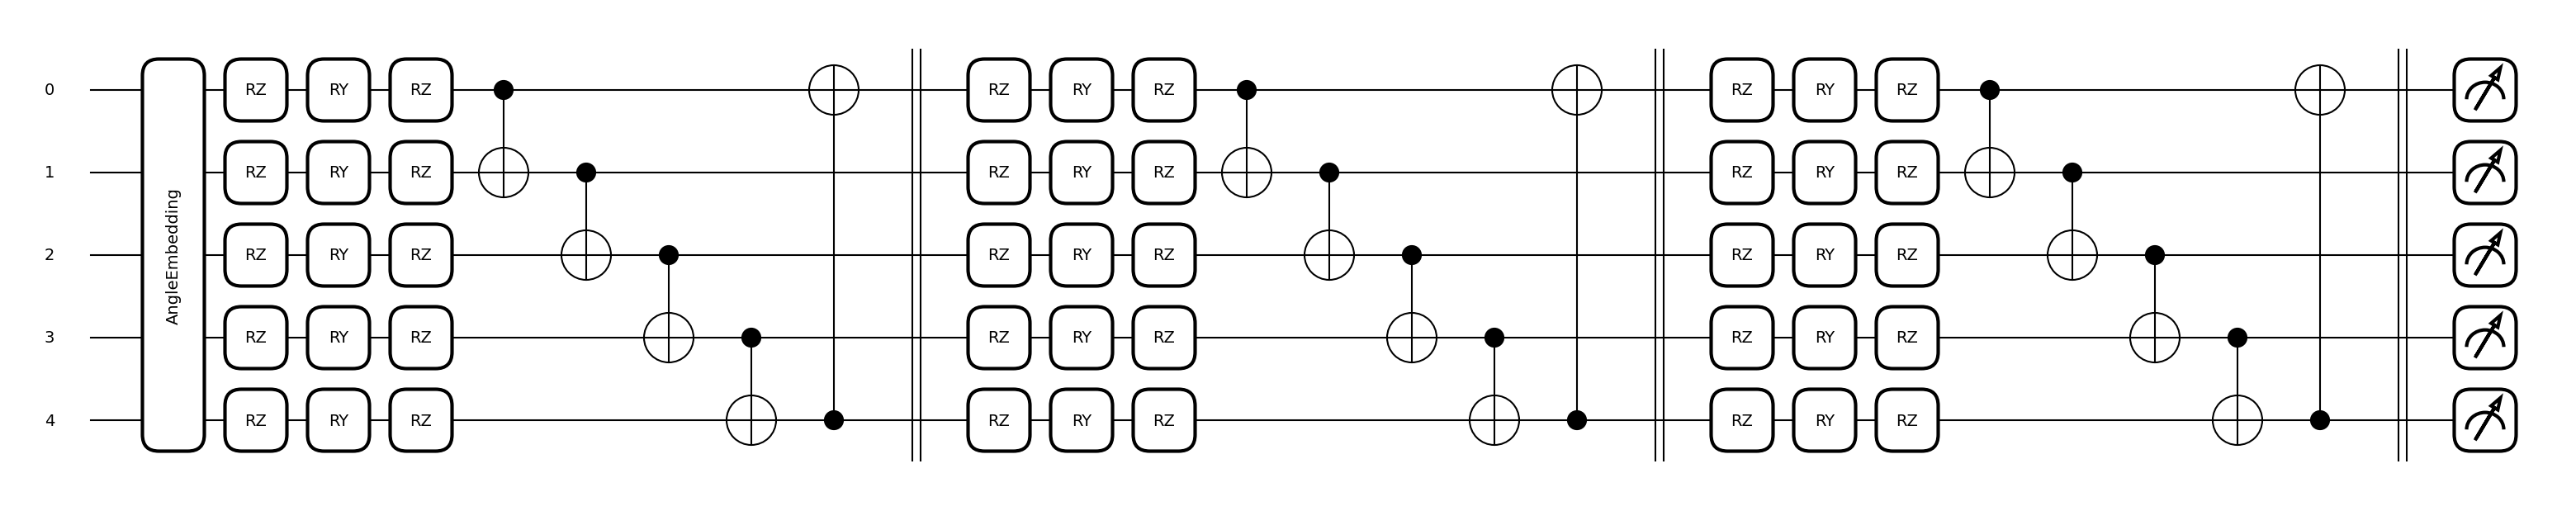

-------------------------------


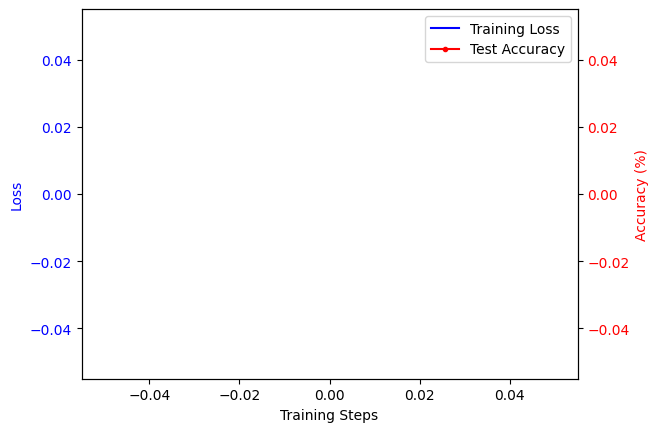


=== Epoch 1/1 ===
  [Train] Starting batch 1/94


Circuit 1/4...:   9%|▉         | 3/32 [00:10<01:45,  3.64s/it]


KeyboardInterrupt: 

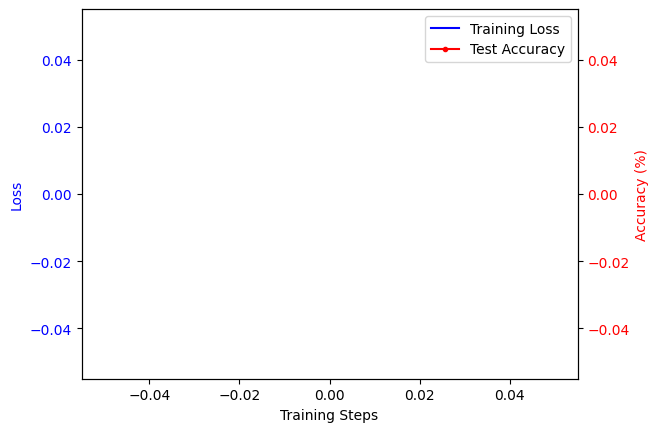

In [19]:
# --- Instantiate and Train the Model ---

# 1. Create the model instance
hqnn_model = HQNNParallel(
    n_circuits = c,
    n_qubits = q,
    depth = depth,
    device = device,
    shots = shots
)

# 2. Load dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data/mnist-parallel/train', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data/mnist-parallel/test', train=False, download=True, transform=transform)

# Get the specified portions of the dataset
train_dataset = torch.utils.data.Subset(train_dataset, range(int(len(train_dataset) * dataset_portion)))
test_dataset = torch.utils.data.Subset(test_dataset, range(int(len(test_dataset) * dataset_portion)))

# 3. Train the model
trained_model = train_model(
    hqnn_model, 
    train_dataset,
    test_dataset, 
    epochs=epochs, 
    batch_size=batch_size,
    classical_learning_rate=classical_learning_rate,
    quantum_learning_rate=quantum_learning_rate,
    plot=True
)

In [ ]:
import os

# Find a unique filename to avoid overwriting existing models
base = 'hqnn_parallel_mnist_ionqsim'
ext = '.pth'
filename = base + ext
counter = 1
while os.path.exists(filename):
    filename = f"{base}_{counter}{ext}"
    counter += 1

# Save the model to a unique file
# torch.save(model.state_dict(), filename)
print(f"Model saved to {filename}")

In [ ]:
def load_model(filepath):
    state_dict = torch.load(filepath)

    # Create a new model instance with the same architecture
    loaded_model = HQNNParallel(
        n_circuits=c,  # Using values defined elsewhere
        n_qubits=q,
        depth=depth,
        device=device,
        shots=shots
    )
    # Load the state dictionary
    loaded_model.load_state_dict(state_dict)
    return loaded_model

In [ ]:
# --- Prediction on New Images ---
def predict_image(model, image_tensor):
    # Now we have a proper model instance
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
        
        # Print probabilities for each class
        for i, prob in enumerate(probabilities[0]):
            print(f"Class {i}: {prob:.4f}")
            
        confidence, predicted_class = torch.max(probabilities, 1)

    if image_tensor.shape[0] == 1:
        return predicted_class.item(), confidence.item()
    else:
        return predicted_class.tolist(), confidence.tolist()

--- Quantum Circuit Structure ---


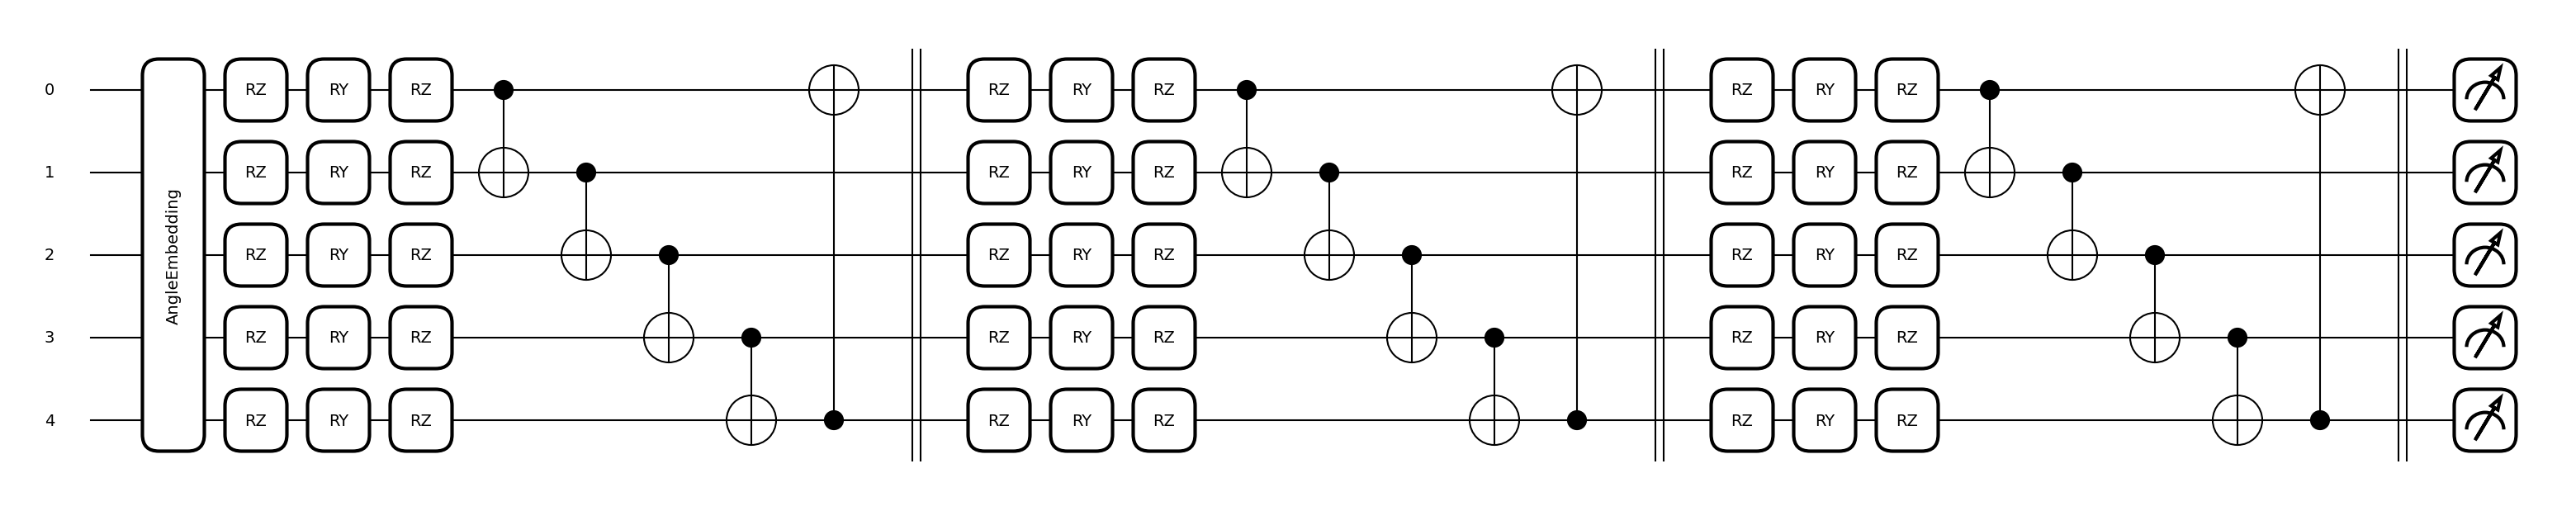

-------------------------------


IndexError: range object index out of range

In [ ]:
# 4. Test prediction on a single image
# Load the model from file
model_from_path = load_model('hqnn_parallel_mnist.pth')

img, label = test_dataset[101]
img_batch = img.unsqueeze(0)  # Add batch dimension

predicted, confidence = predict_image(model_from_path, img_batch)
print(f"\n--- Prediction ---")
print(f"True Label: {label}")
print(f"Predicted Label: {predicted} with confidence {confidence:.4f}")

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted}, True: {label}")
plt.show()